# Cats vs dogs

## Convnet example

### Data

The data is provided by kaggle, unfortunately the download link is not public, you will need to create an account at kaggle.com (it is free) and then download

https://www.kaggle.com/c/dogs-vs-cats/download/train.zip

Note that they file name is "train.zip" and it contains all the labeled data, we will need to split that into our train, validation and test set.

Once you have all the data, unzip it into a dir named "data" in the same directory of this jupyter notebook.


In [5]:
# Lets import some stuff
import tensorflow as tf
from skimage import io
from IPython.display import Image
#from skimage.transform import resize
import matplotlib.pyplot as plt
from os import listdir
from os import mkdir
from skimage.io import imsave
import numpy as np
from sklearn.utils import shuffle
import sys
#import os
import cv2


#print("Installed version of tensorflow is ", tf.__version__)
print("Important! tensorflow MUST be 1.2 or higher for this to work fine...")

Important! tensorflow MUST be 1.2 or higher for this to work fine...


### Explore the dataset

The definition of kaggle dataset is 

"The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat)."

Notice! your direcory should look like this (once you have uncompressed the data)
```
.
├── cats-vs-dogs.ipynb
└── data
    └── train [25000 entries exceeds filelimit, not opening dir]
            ├── cat.2976.jpg
            ├── dog.2977.jpg
            ├── cat.2978.jpg
            ├── dog.2979.jpg
            ├── ...

```
Of course images named cat.xxx.jpg are cats and thesame goes for the ones started with dogs.

Lets open a few images


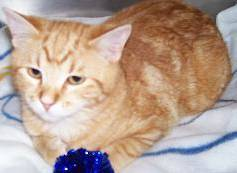

In [6]:
DATA_DIR = "data/train/"
Image(filename=DATA_DIR+'cat.42.jpg')


Also, lets show a dog

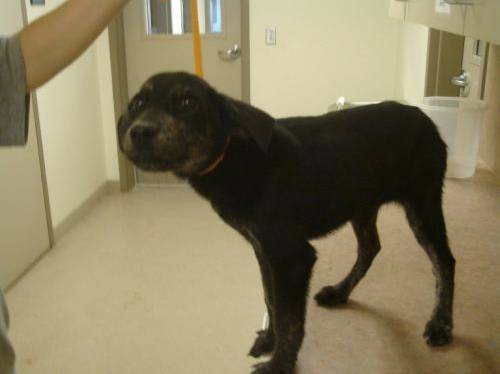

In [7]:
Image(filename=DATA_DIR+'dog.42.jpg')

The first obvious thing is that we are dealing here with images of different sizes, we need to make them the same size. Of course bigger sizes will mean more data, which means more processing time... For our example we will modify all images to be 100x100 pixels

In [8]:
IMAGE_WIDTH=100
IMAGE_HEIGHT=100

Lets read one cat image and transform it.

In [27]:
def resize_and_pad(img, size, padColor=0):
    # Credits goes to 
    # https://stackoverflow.com/questions/44720580/resize-image-canvas-to-maintain-square-aspect-ratio-in-python-opencv
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, 
                                    pad_left, pad_right, 
                                    borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [28]:
original = cv2.imread(DATA_DIR+'cat.42.jpg')
resized = resize_and_pad(original, (100, 100))
print(resized.shape)


(100, 100, 3)


Seems fine... lets convince ourselves it is the same image by displaying it

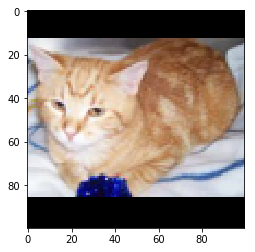

In [29]:
plt.imshow(resized)
plt.show()

The image has been resized, of course this means loosing some data, well, nobody is perfect :)
Now we will need to convert ALL our images and we will store them into a separated directory, we will use that directory for subsequent executions

In [36]:

CLEANED_DATA_DIR = DATA_DIR+"cleaned/"
try:
    mkdir(CLEANED_DATA_DIR)
except:
    pass

def convert_images():
    i = 1
    for image_file in listdir(DATA_DIR):
        if ".jpg" in image_file:
            original = cv2.imread(DATA_DIR+image_file)
            transformed = resize_and_pad(original, (IMAGE_WIDTH, IMAGE_HEIGHT))
            final_file = CLEANED_DATA_DIR+image_file
            imsave(final_file, transformed)
            if i % 500 == 0:
                print("Converted ", i, " images so far...")
            i += 1
    print("Done!")

In [37]:
convert_images()

Converted  500  images so far...
Converted  1000  images so far...
Converted  1500  images so far...
Converted  2000  images so far...
Converted  2500  images so far...
Converted  3000  images so far...
Converted  3500  images so far...
Converted  4000  images so far...
Converted  4500  images so far...
Converted  5000  images so far...
Converted  5500  images so far...
Converted  6000  images so far...
Converted  6500  images so far...
Converted  7000  images so far...
Converted  7500  images so far...
Converted  8000  images so far...
Converted  8500  images so far...
Converted  9000  images so far...
Converted  9500  images so far...
Converted  10000  images so far...
Converted  10500  images so far...
Converted  11000  images so far...
Converted  11500  images so far...
Converted  12000  images so far...
Converted  12500  images so far...
Converted  13000  images so far...
Converted  13500  images so far...
Converted  14000  images so far...
Converted  14500  images so far...
Conve

Now, we will read the new files and load them, we will load cats and dogs separately (just for convenience), then we will split them into train, validation and test set. 

* Train set 80% of the images
* Validation set 10% of the images
* Test set 10% of the images

In [38]:
CAT_LABEL = 1
DOG_LABEL = 0

def load_data(limit=None):
    """
    Gets all the data and returns
    X_train_cats, y_train_cats
    X_train_dogs, y_train_dogs
    X_validation_cats, y_validation_cats
    X_validation_dogs, y_validation_dogs
    X_test_cats, y_test_cats
    X_test_dogs, y_test_dogs
    """
    dogs = []
    cats = []
    i = 1
    if limit == None:
        limit = 50000
    for image_file in listdir(CLEANED_DATA_DIR):        
        if ".jpg" in image_file:
            if "dog" in image_file and len(dogs) < limit:
                raw_image = io.imread(CLEANED_DATA_DIR+image_file)
                dogs.append(raw_image)
            elif "cat" in image_file and len(cats) < limit:
                raw_image = io.imread(CLEANED_DATA_DIR+image_file)
                cats.append(raw_image)
        if i % 500 == 0:
            print("Loaded ", i, " images so far...")
        i+=1    
            
    return cats, dogs

In [40]:
cats, dogs = load_data(5000)

Loaded  500  images so far...
Loaded  1000  images so far...
Loaded  1500  images so far...
Loaded  2000  images so far...
Loaded  2500  images so far...
Loaded  3000  images so far...
Loaded  3500  images so far...
Loaded  4000  images so far...
Loaded  4500  images so far...
Loaded  5000  images so far...
Loaded  5500  images so far...
Loaded  6000  images so far...
Loaded  6500  images so far...
Loaded  7000  images so far...
Loaded  7500  images so far...
Loaded  8000  images so far...
Loaded  8500  images so far...
Loaded  9000  images so far...
Loaded  9500  images so far...
Loaded  10000  images so far...
Loaded  10500  images so far...
Loaded  11000  images so far...
Loaded  11500  images so far...
Loaded  12000  images so far...
Loaded  12500  images so far...
Loaded  13000  images so far...
Loaded  13500  images so far...
Loaded  14000  images so far...
Loaded  14500  images so far...
Loaded  15000  images so far...
Loaded  15500  images so far...
Loaded  16000  images so far

Now we need to split our data into train, validation and test sets. As there are as many cats as there are dogs, we want to keep our sets balanced, with approximately 50% of cats and 50% of dogs. 

In [41]:
train_limit = int(len(cats) * 0.8)
validation_limit = train_limit + int(len(cats) * 0.1)

X_train_cats = np.array(cats[:train_limit])
X_train_dogs = np.array(dogs[:train_limit])
X_validation_cats = np.array(cats[train_limit:validation_limit])
X_validation_dogs = np.array(dogs[train_limit:validation_limit])
X_test_cats = np.array(cats[validation_limit:])
X_test_dogs = np.array(dogs[validation_limit:])

### Now we need to create our labels, remember that we have dined our labels as variables 
```
CAT_LABEL = 1
DOG_LABEL = 0
```

Meaning that cats are labelled as 1 and dogs as 0s

In [42]:
y_train_cats = np.ones(len(X_train_cats), dtype=np.int8)
y_train_dogs = np.zeros(len(X_train_dogs), dtype=np.int8)
y_validation_cats = np.ones(len(X_validation_cats), dtype=np.int8)
y_validation_dogs = np.zeros(len(X_validation_dogs), dtype=np.int8)
y_test_cats = np.ones(len(X_test_cats), dtype=np.int8)
y_test_dogs = np.zeros(len(X_test_dogs), dtype=np.int8)

y_train_cats.shape

(4000,)

In [43]:
X_train = np.append(X_train_cats, X_train_dogs, axis=0)
y_train = np.append(y_train_cats, y_train_dogs)
X_validation = np.append(X_validation_cats, X_validation_dogs, axis=0)
y_validation = np.append(y_validation_cats, y_validation_dogs)
X_test = np.append(X_test_cats, X_test_dogs, axis=0)
y_test = np.append(y_test_cats, y_test_dogs)

### Lets convert labels into one-hot-encoded values

In [44]:
y_train_one_hot = np.eye(2)[y_train.reshape(-1)]
y_validation_one_hot = np.eye(2)[y_validation.reshape(-1)]
y_test_one_hot = np.eye(2)[y_test.reshape(-1)]

### Now, lets make sure the arrays are in the correct shape

In [45]:
print("X_train ", X_train.shape, " y_train_one_hot ", y_train_one_hot.shape)
print("X_validation ", X_validation.shape, " y_validation_one_hot ", y_validation_one_hot.shape)
print("X_test ", X_test.shape, " y_test_one_hot ", y_test_one_hot.shape)

X_train  (8000, 100, 100, 3)  y_train_one_hot  (8000, 2)
X_validation  (1000, 100, 100, 3)  y_validation_one_hot  (1000, 2)
X_test  (1000, 100, 100, 3)  y_test_one_hot  (1000, 2)


### And finally shuffle the arrays so that our batches are not all dogs or all cats

In [46]:
X_train, y_train_one_hot, y_train = shuffle(X_train, y_train_one_hot, y_train, 
                                            random_state=0)
X_validation, y_validation_one_hot, y_validation = shuffle(X_validation, y_validation_one_hot, y_validation, 
                                                           random_state=0)
X_test, y_test_one_hot, y_test = shuffle(X_test, y_test_one_hot, y_test, 
                                 random_state=0)

In [47]:
print(y_train[0:10])
print(y_train_one_hot[0:10])

[1 1 0 1 1 1 0 1 1 0]
[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


### Now, lets veryfy that we have shuffled correctly, we will display the first ten images of the train set and check that against the first 10 labels

[ 0.  1.]
This should be a cat...


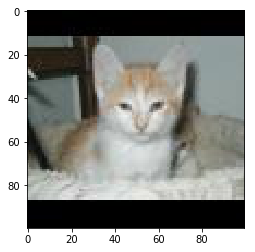

[ 0.  1.]
This should be a cat...


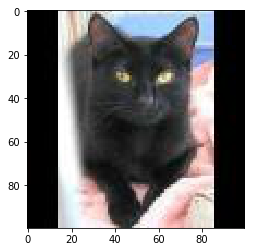

[ 1.  0.]
This should be a dog...


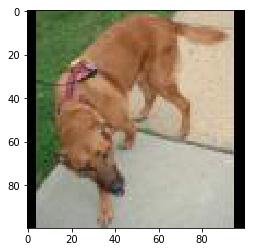

[ 0.  1.]
This should be a cat...


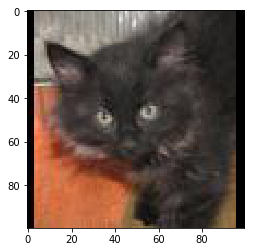

[ 0.  1.]
This should be a cat...


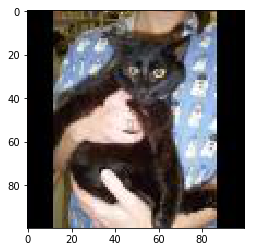

[ 0.  1.]
This should be a cat...


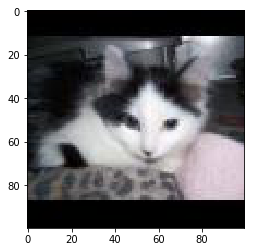

[ 1.  0.]
This should be a dog...


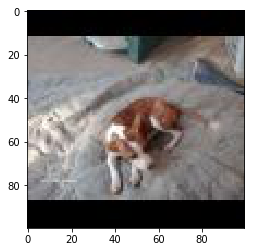

[ 0.  1.]
This should be a cat...


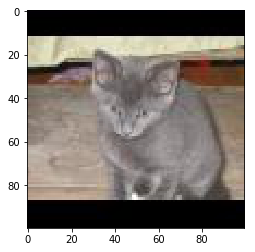

[ 0.  1.]
This should be a cat...


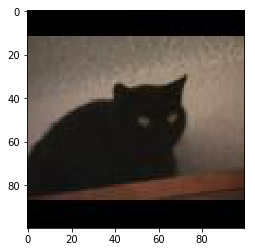

[ 1.  0.]
This should be a dog...


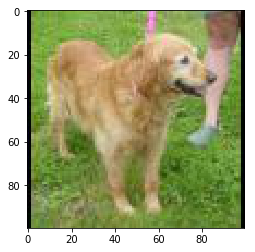

In [48]:
for i in range(10):
    label = y_train_one_hot[i]
    print(label)
    if label[DOG_LABEL] == 1:
        print("This should be a dog...")
        
    elif label[CAT_LABEL] == 1:
        print("This should be a cat...")
    
    plt.imshow(X_train[i])
    plt.show()

### We still need to normalize our data, remember that normalization is done with the following formula
![title](normalization.png)

In [49]:
def normalize(raw_data):
    min_value = np.min(raw_data)
    max_value = np.max(raw_data)
    # Min and max values are 0 and 255
    result = (raw_data - 0) / (255 - 0)
    return result


X_train_normalized = normalize(X_train)
X_validation_normalized = normalize(X_validation)
X_test_normalized = normalize(X_test)


In [54]:
# And remove some data we have in memory but we do not need anymore
del cats
del dogs
del X_train
del X_test
del X_validation
del X_train_cats 
del X_train_dogs
del X_validation_cats
del X_validation_dogs
del X_test_cats
del X_test_dogs

In [55]:
X_train_normalized[1].shape

(100, 100, 3)

### Machine learning! (at last!)

Things to do are

* Define hyperparameters
* Build the network itself
  * Placeholder definitions
  * Code perse
* Write the training code

In [86]:
def next_batch(X, y, batchSize):
    # loop over our dataset `X` in mini-batches of size `batchSize`
    for i in np.arange(0, X.shape[0], batchSize):
        # yield a tuple of the current batched data and labels
        yield (X[i:i + batchSize,], y[i:i + batchSize,])

#### Define hyperparameters

In [94]:
FULLY_CONNECTED_LAYER_1 = 1024
FULLY_CONNECTED_LAYER_2 = 1024
CONVOLUTION_1_OUTPUT = 16
CONVOLUTION_2_OUTPUT = 32
CONVOLUTION_3_OUTPUT = 64
BATCH_SIZE = 128
EPOCHS = 100
TOTAL_BATCHES = X_train_normalized.shape[0] // BATCH_SIZE
LABELS = 2 # Either cats or dogs

#### Build the network itself

In [95]:
X = tf.placeholder(tf.float32, shape=(None, IMAGE_WIDTH, IMAGE_HEIGHT, 3), name="X")
y = tf.placeholder(tf.float32, shape=(None, LABELS), name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

In [96]:
# First convolution, turn the image into 100x100xCONVOLUTION_1_OUTPUT

convolution_1 = tf.layers.conv2d(X,    
                                 CONVOLUTION_1_OUTPUT, # Output size
                                 (3,3), # Kernel/patch size
                                 strides=(1,1), 
                                 padding="SAME",
                                 activation=tf.nn.relu)

#Max pool to reduce image from 100x100xCONVOLUTION_1_OUTPUT to 33x33xCONVOLUTION_1_OUTPUT 

convolution_1 = tf.layers.max_pooling2d(convolution_1, 
                                        3,  # Kernel/patch size 
                                        3,  # Strides, this will effectively shrink the output dimension, making 
                                            # it 100 / 3 = 33.3 ~ 34
                                        padding="SAME")

# Second convolution, turn the image into 34x34xCONVOLUTION_2_OUTPUT
convolution_2 = tf.layers.conv2d(convolution_1,    
                                 CONVOLUTION_2_OUTPUT, # Output size
                                 (3,3), # Kernel/patch size
                                 strides=(1,1), 
                                 padding="SAME",
                                 activation=tf.nn.relu)

#Max pool to reduce image from 34x34xCONVOLUTION_2_OUTPUT to 11x11xCONVOLUTION_2_OUTPUT
convolution_2 = tf.layers.max_pooling2d(convolution_2, 
                                        3,  # Kernel/patch size 
                                        3,  # Strides, this will effectively shrink the output dimension, making 
                                            # it 34 / 2 = 12
                                        padding="SAME")



convolution_3 = tf.layers.conv2d(convolution_2, 
                                CONVOLUTION_3_OUTPUT,
                                (3,3),
                                strides=(1,1),
                                padding="SAME",
                                activation=tf.nn.relu)



convolution_3 = tf.layers.max_pooling2d(convolution_3,
                                       3,
                                       3,
                                       padding="SAME")

# So the output of the convolution is 12x12x32 = 4608, lets use that for a "normal" neural network

fully_connected_1 = tf.layers.dense(tf.reshape(convolution_3, (-1, 4*4*64)),
                                FULLY_CONNECTED_LAYER_1, 
                                activation=tf.nn.relu)

fully_connected_1 = tf.nn.dropout(fully_connected_1, keep_prob)

fully_connected_2 = tf.layers.dense(fully_connected_1,
                                FULLY_CONNECTED_LAYER_2, 
                                activation=tf.nn.relu)

fully_connected_2 = tf.nn.dropout(fully_connected_2, keep_prob)

logits = tf.layers.dense(fully_connected_2, 
                              LABELS)  

predictions = tf.nn.softmax(logits)

softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)


#train_step = tf.train.AdamOptimizer().minimize(error)

print(X_train_normalized.shape)

(8000, 100, 100, 3)


#### Write the training code

In [ ]:
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
dropout_training = 0.5
dropout_predicting = 1.0
debug = True
for epoch_no in range(EPOCHS):
    for batch_no in range(TOTAL_BATCHES):
        start_at = batch_no
        slice_start = start_at*BATCH_SIZE
        slice_end = slice_start + BATCH_SIZE
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*BATCH_SIZE
            slice_end = slice_start + BATCH_SIZE
            print("From ", slice_start, "--", slice_end)
    
    
        my_X = X_train_normalized[slice_start:slice_end]
        my_y = y_train_one_hot[slice_start:slice_end]


        if debug:
            print("Convolution_1", convolution_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Convolution_2", convolution_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Convolution_3", convolution_3.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Fully connected_1", fully_connected_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y,
                                                                keep_prob: dropout_training}).shape)
            print("Fully connected_2", fully_connected_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y,
                                                                keep_prob: dropout_training}).shape)
            
            debug = False

        train_step.run(feed_dict={X: my_X, 
                                  y: my_y,
                                  keep_prob: dropout_training})

        correct_prediction_val = tf.equal(tf.argmax(y_validation_one_hot,1), tf.argmax(predictions, 1))
        accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))

        correct_prediction_train_batch = tf.equal(tf.argmax(my_y,1), tf.argmax(predictions, 1))
        accuracy_train_batch = tf.reduce_mean(tf.cast(correct_prediction_train_batch, tf.float32))
        if batch_no % 12 == 0:
            print("Batch", batch_no, "/", TOTAL_BATCHES, "completed...")
    print("Epoch ", epoch_no, 
          " batch number ", batch_no, 
          " cost ", cost.eval(feed_dict={X: my_X, 
                                         y: my_y,
                                         keep_prob: dropout_training}),
          " \tval accuracy ", accuracy_val.eval(feed_dict={X: X_validation_normalized, 
                                                           y: y_validation_one_hot,
                                                           keep_prob: dropout_predicting}),
          "\ttrain accuracy", accuracy_train_batch.eval(feed_dict={X: my_X, 
                                                                   y: my_y,
                                                                   keep_prob: dropout_training}))

        
print("DONE!!")        

Convolution_1 (128, 34, 34, 16)
Convolution_2 (128, 12, 12, 32)
Convolution_3 (128, 4, 4, 64)
Fully connected_1 (128, 1024)
Fully connected_2 (128, 1024)
Batch 0 / 62 completed...
Batch 12 / 62 completed...
Batch 24 / 62 completed...
Batch 36 / 62 completed...
Batch 48 / 62 completed...
Batch 60 / 62 completed...
Epoch  0  batch number  61  cost  0.691344  	val accuracy  0.549 	train accuracy 0.554688
Batch 0 / 62 completed...
Batch 12 / 62 completed...
Batch 24 / 62 completed...
Batch 36 / 62 completed...
Batch 48 / 62 completed...
Batch 60 / 62 completed...
Epoch  1  batch number  61  cost  0.654387  	val accuracy  0.6 	train accuracy 0.523438
Batch 0 / 62 completed...
Batch 12 / 62 completed...
Batch 24 / 62 completed...
Batch 36 / 62 completed...
Batch 48 / 62 completed...
Batch 60 / 62 completed...
Epoch  2  batch number  61  cost  0.643023  	val accuracy  0.647 	train accuracy 0.609375
Batch 0 / 62 completed...
Batch 12 / 62 completed...
Batch 24 / 62 completed...
Batch 36 / 62 c

Batch 12 / 62 completed...
Batch 24 / 62 completed...
Batch 36 / 62 completed...
Batch 48 / 62 completed...
Batch 60 / 62 completed...
Epoch  32  batch number  61  cost  0.299592  	val accuracy  0.758 	train accuracy 0.835938
Batch 0 / 62 completed...
Batch 12 / 62 completed...
Batch 24 / 62 completed...
Batch 36 / 62 completed...
Batch 48 / 62 completed...
Batch 60 / 62 completed...
Epoch  33  batch number  61  cost  0.326135  	val accuracy  0.748 	train accuracy 0.859375
Batch 0 / 62 completed...
Batch 12 / 62 completed...
Batch 24 / 62 completed...
Batch 36 / 62 completed...
Batch 48 / 62 completed...
Batch 60 / 62 completed...
Epoch  34  batch number  61  cost  0.347412  	val accuracy  0.761 	train accuracy 0.867188
Batch 0 / 62 completed...
Batch 12 / 62 completed...
Batch 24 / 62 completed...
Batch 36 / 62 completed...
Batch 48 / 62 completed...
Batch 60 / 62 completed...
Epoch  35  batch number  61  cost  0.279734  	val accuracy  0.762 	train accuracy 0.875
Batch 0 / 62 complete

## Perform predictions

In [91]:
def perform_prediction(file_name, predictions_tensor):
    resized = np.empty((1, 100, 100, 3))  # Prepare array to store image
        
    #Read image, reshape it and display it
    raw_image = cv2.imread(file_name)
    resized_image = cv2.resize(raw_image, (100, 100))
    plt.imshow(resized_image)
    plt.show()
    
    # Reshape again to 28*28, normalize and perform prediction
    resized[0] = resized_image
    
    normalized = (resized - 0) / (255 - 0)
    predicted = predictions_tensor.eval(feed_dict={X: normalized, keep_prob: dropout_predicting})
    # Plot the predictions
    # Remember
    # CAT_LABEL = 1
    # DOG_LABEL = 0
    possible_answers = [0, 1]
    my_prediction = predicted[0, :]    
    print(predicted.shape)
    plt.bar(possible_answers, my_prediction, color="red")
    plt.xticks(possible_answers, possible_answers)
    plt.title("Prediction")
    plt.show()

   
  

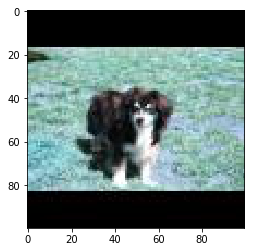

(1, 2)


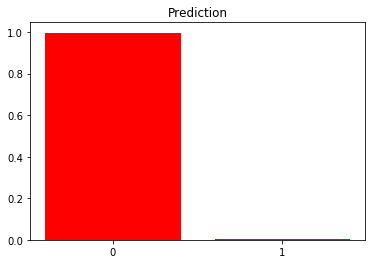

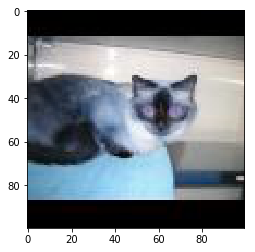

(1, 2)


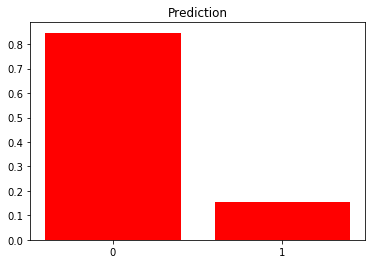

----------------------------------------------------------------------


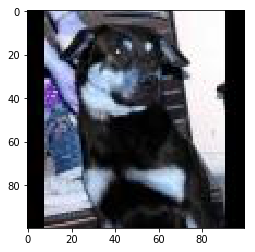

(1, 2)


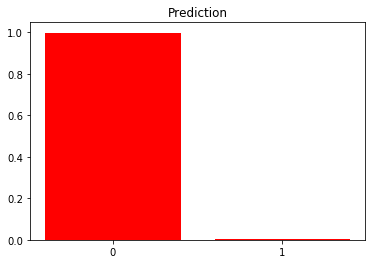

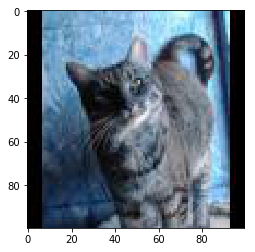

(1, 2)


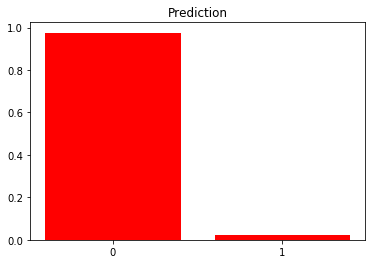

----------------------------------------------------------------------


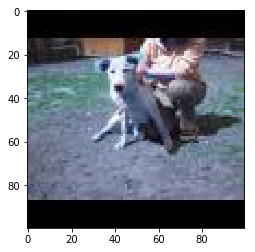

(1, 2)


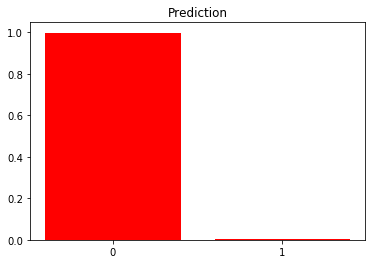

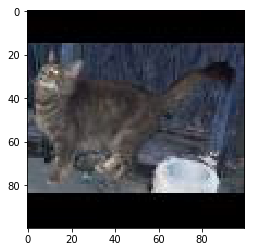

(1, 2)


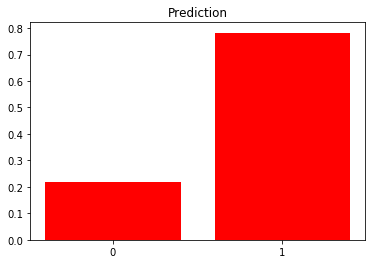

----------------------------------------------------------------------


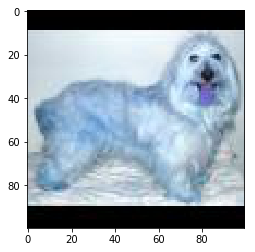

(1, 2)


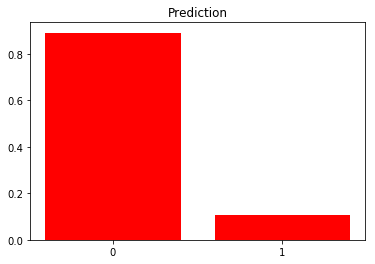

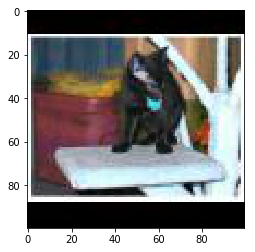

(1, 2)


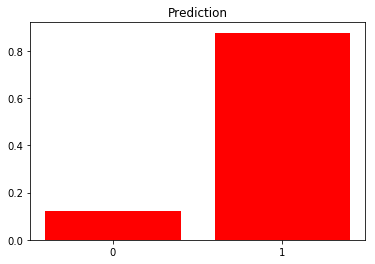

----------------------------------------------------------------------


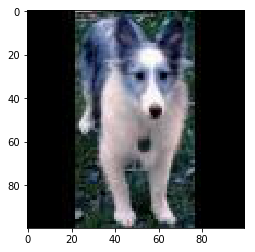

(1, 2)


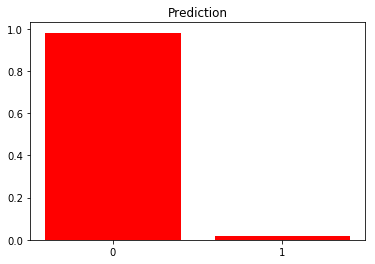

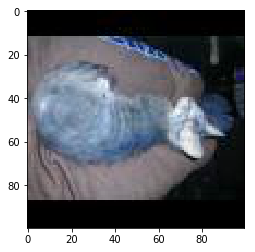

(1, 2)


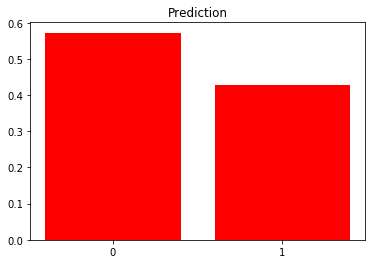

----------------------------------------------------------------------


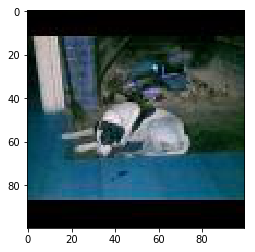

(1, 2)


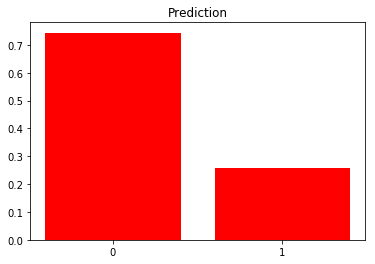

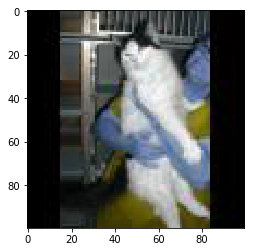

(1, 2)


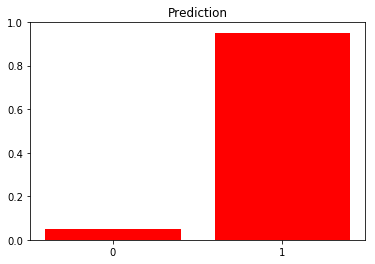

----------------------------------------------------------------------


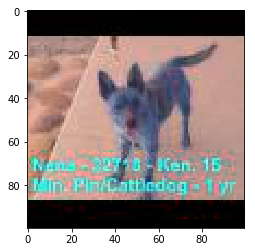

(1, 2)


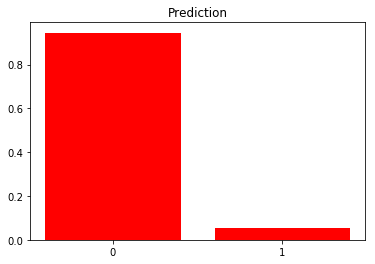

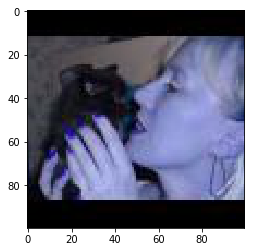

(1, 2)


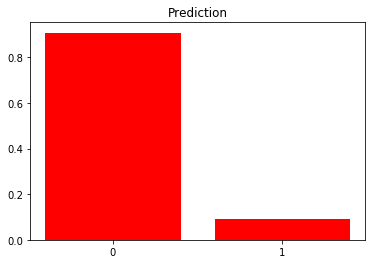

----------------------------------------------------------------------


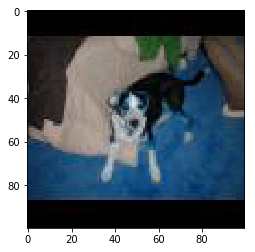

(1, 2)


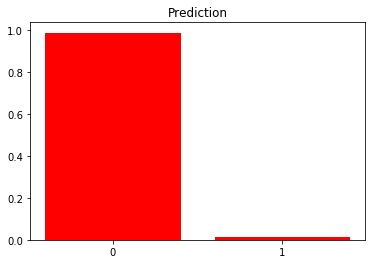

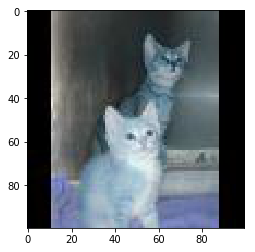

(1, 2)


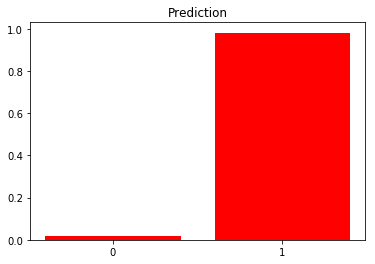

----------------------------------------------------------------------


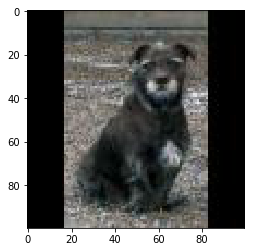

(1, 2)


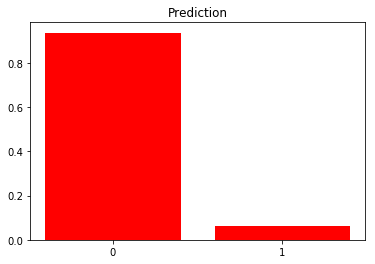

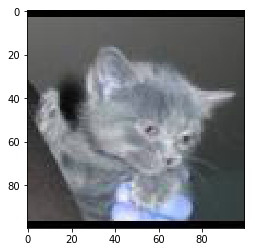

(1, 2)


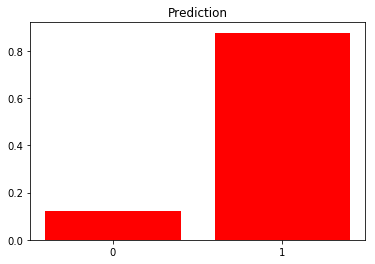

----------------------------------------------------------------------


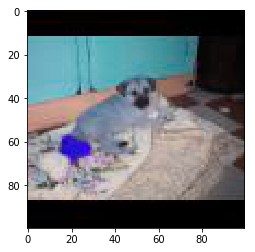

(1, 2)


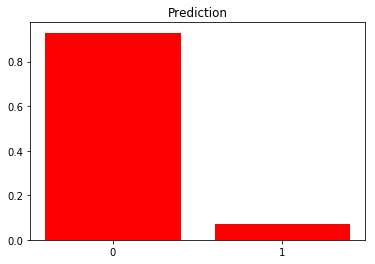

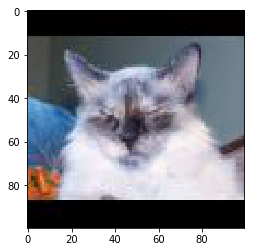

(1, 2)


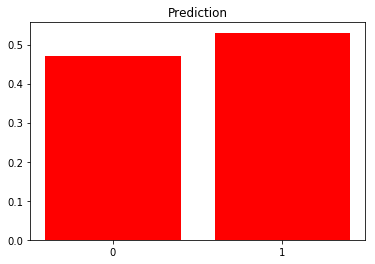

----------------------------------------------------------------------


In [93]:
for i in range(10):
    perform_prediction("data/train/cleaned/dog.2%d.jpg" % i, predictions)
    perform_prediction("data/train/cleaned/cat.2%d.jpg" % i, predictions)
    print("----------------------------------------------------------------------")